In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
from pandas.util.testing import assert_frame_equal

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.append("..")
from btc_predictor.utils import preproc

In [2]:
df = pd.read_csv("../btc_predictor/datasets/btcusd.csv")

# 1. Preprocessing

In [3]:
# Change Date to datetime format, sort the whole dataframe by date in ascending order, 
# and then make Date the index.
df.Date = pd.to_datetime(df.Date)
df = df.sort_values(by = 'Date')
df.set_index('Date', inplace=True)

In [4]:
# Change formatting and cast all number strings into numeric values
df.Open = df.Open.str.replace(",", "")
df.High = df.High.str.replace(",", "")
df.Low = df.Low.str.replace(",", "")
df.Close = df.Close.str.replace(",", "")
df.Volume = df.Volume.str.replace(",", "")
df["Market Cap"] = df["Market Cap"].str.replace(",", "")
df.Volume = df.Volume.replace("-", np.nan)
df = df.apply(pd.to_numeric)
df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,NaN,1488566728
2013-04-29,134.44,147.49,134.00,144.54,NaN,1603768865
2013-04-30,144.00,146.93,134.05,139.00,NaN,1542813125
2013-05-01,139.00,139.89,107.72,116.99,NaN,1298954594
2013-05-02,116.38,125.60,92.28,105.21,NaN,1168517495


In [5]:
df.dtypes

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap      int64
dtype: object

In [6]:
df.shape

(2274, 6)

## 1.1 Verifying Preprocessing Function

After we implemented our preprocessing in utils.py, we need to verify that it works exactly the same as our preprocessing steps above.

In [7]:
df2 = pd.read_csv("../btc_predictor/datasets/btcusd.csv")#, index_col='Date')

In [8]:
df2 = preproc(df2)
assert_frame_equal(df, df2)

## 1.2 Visualizations

Our goal is to predict the Closing price of BTCUSD. So lets plot it andwhat it looks like.

In [9]:
BTCUSD = df.copy()

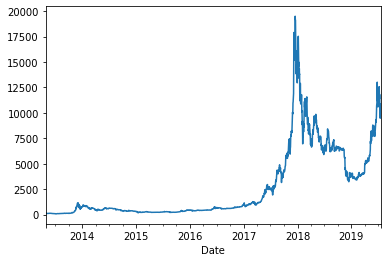

In [10]:
BTCUSD.Close.plot.line();

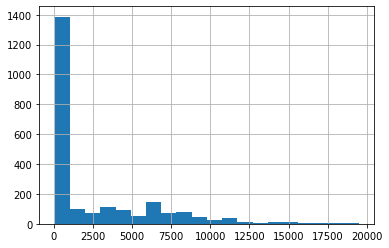

In [11]:
BTCUSD.Close.hist(bins=20);

In [12]:
BTCUSD.Close.mean(), BTCUSD.Close.std()

(2641.8530958663146, 3527.656849520257)

We will also visualize BTCUSD Close price and its autocorrelations. We will plot the correlation between current return with its one to 30 day lag return.

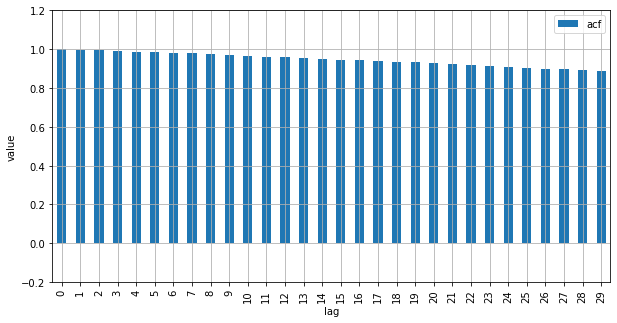

In [13]:
results = {}
nlags=30
results["acf"] = acf(BTCUSD.Close, unbiased=True, nlags=nlags-1, fft=False)

pd.DataFrame(results).plot(kind="bar", figsize=(10,5), grid=True)
plt.xlabel("lag")
plt.ylim([-0.2, 1.2])
plt.ylabel("value")
plt.show()

From the visualizations, we can conclude that the closing price of BTC is not a stationary time series, which means any predictive model trained for one period will not work for other periods.  

To further confirm our visual conclusion, let's run Dickey-Fuller test to test stationarity.

$H_0:$ BTCUSD Close price has an unit root, has a time-dependent structure and thus non-stationary.

In [21]:
# Check for log Close price series stationarity
result = adfuller(np.log(BTCUSD.Close))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.162675
p-value: 0.970089
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Since p-value > 0.05, we cannot reject $H_0$. Thus, BTCUSD Close price has a unit root, is non-stationary, and has time-dependent structure. 

## 1.3 Making Time Series Stationary

Since BTCUSD Close is non stationary, we need to make it stationary for predictions. Time series usually has three components: `trend`, `seasonality`, and `residual`.  We can extract `trend` and `seasonality` away from the BTCUSD Close price and try to predict the `residuals`. But upon visual inspection of BTCUSD Close, There's no obvious trend nor seasonality. So we will make it stationary with its log returns. We use log returns instead of geometric or arithmetic returns as it is 1) log normal, 2) approximate raw-log equality, 3) time-additivity, and 4) ease of integration.

In [15]:
BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))
BTCUSD.dropna(inplace=True)

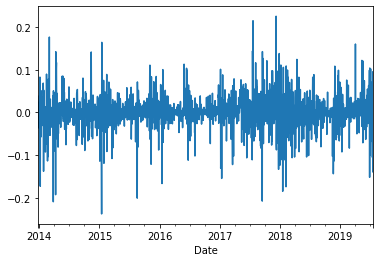

In [16]:
BTCUSD.log_ret.plot.line();

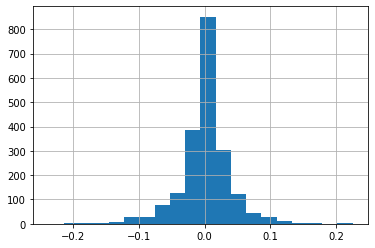

In [17]:
BTCUSD.log_ret.hist(bins=20);

In [18]:
BTCUSD.log_ret.mean(), BTCUSD.log_ret.std()

(0.0012930244312348892, 0.03959499294102235)

Next, we will plot a correlogram to visualize the autocorrelations of log return of BTCUSD Close.

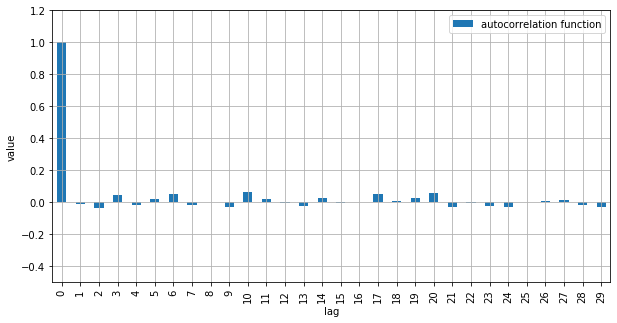

In [19]:
results = {}
nlags=30
results["autocorrelation function"] = acf(BTCUSD.log_ret, unbiased=True, nlags=nlags-1, fft=False)

pd.DataFrame(results).plot(kind="bar", figsize=(10,5), grid=True)
plt.xlabel("lag")
plt.ylim([-0.5, 1.2])
plt.ylabel("value")
plt.show()

The log return of closing price of BTCUSD looks like a stationary time series, which means any predictive model trained for one period will work for other periods.  Let's do a quick stationarirty test with Dickey-Fuller test.

$H_0:$ log return of BTCUSD Close has an unit root, has a time-dependent structure and thus non-stationary.

In [20]:
# Check for log_ret series stationarity.  
result = adfuller(BTCUSD.log_ret)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.391688
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Since p-value < 0.05, we can reject the null hypothesis that time series has a unit root and non-stationary and has time-dependent structure. Also, since we are able to achieve stationarity in first order differencing, we will not proceed to check higher order differencing.

Also, from the correlgram above, we see prounced autocorrelation at 3, 6, 10, 17, and 20 period lag. We will keep in mind when we engineer new features.